In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [2]:
dataset = load_dataset("A2H0H0R1/plant-disease", split="train")
dataset = dataset.shuffle(seed=42)
labels_list = dataset['label']
le = LabelEncoder()
le.fit(labels_list)
def encode_label(example):
    example['label'] = le.transform([example['label']])[0]
    return example

dataset = dataset.map(encode_label)
train_test = dataset.train_test_split(test_size=0.25)
train_ds = train_test["train"]
test_ds = train_test["test"]
print(train_test)
print(train_ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/347M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/392M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/70295 [00:00<?, ? examples/s]

Map:   0%|          | 0/70295 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 52721
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 17574
    })
})
Dataset({
    features: ['image', 'label'],
    num_rows: 52721
})


In [3]:
def transform(example):
    img = tf.keras.utils.img_to_array(example["image"])
    img = tf.image.resize(img, [256, 256])
    img = preprocess_input(img)
    label = example["label"]
    return img, label

# Use generator function for streaming (not to numpy)
def gen(dataset):
    for ex in dataset:
        yield transform(ex)

output_signature = (
    tf.TensorSpec(shape=(256,256,3), dtype=tf.float32),   # adjust as needed
    tf.TensorSpec(shape=(), dtype=tf.int64),
)
ds_train = tf.data.Dataset.from_generator(lambda: gen(train_ds), output_signature=output_signature)
ds_train = ds_train.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)  # batching keeps RAM low!
ds_test = tf.data.Dataset.from_generator(lambda: gen(test_ds), output_signature=output_signature)
ds_test = ds_test.batch(32).prefetch(tf.data.AUTOTUNE)  # batching keeps RAM low!

In [4]:
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
convolutional_base.trainable = False
convolutional_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
num_of_classes = len(le.classes_)


model = models.Sequential([
    convolutional_base,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(num_of_classes, activation='softmax')
])

In [6]:
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(ds_train, validation_data = ds_test, epochs=10)

Epoch 1/10
   1648/Unknown 432s 248ms/step - accuracy: 0.3460 - loss: 2.5652

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1648/1648 ━━━━━━━━━━━━━━━━━━━━ 571s 332ms/step - accuracy: 0.3461 - loss: 2.5649 - val_accuracy: 0.9299 - val_loss: 0.8156
Epoch 2/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 526s 317ms/step - accuracy: 0.6818 - loss: 1.4080 - val_accuracy: 0.9587 - val_loss: 0.4007
Epoch 3/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 523s 314ms/step - accuracy: 0.7725 - loss: 0.9976 - val_accuracy: 0.9735 - val_loss: 0.2390
Epoch 4/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 524s 315ms/step - accuracy: 0.8235 - loss: 0.7453 - val_accuracy: 0.9771 - val_loss: 0.1596
Epoch 5/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 521s 313ms/step - accuracy: 0.8515 - loss: 0.6078 - val_accuracy: 0.9793 - val_loss: 0.1183
Epoch 6/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 531s 320ms/step - accuracy: 0.8746 - loss: 0.4988 - val_accuracy: 0.9811 - val_loss: 0.0937
Epoch 7/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 519s 313ms/step - accuracy: 0.8888 - loss: 0.4344 - val_accuracy: 0.9824 - val_loss: 0.0803
Epoch 8/10
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 524s 315ms/step - accuracy: 0.8

In [8]:
model.save("/content/plant_disease_model.h5")

In [9]:
loss, accuracy = model.evaluate(ds_test)
print('Test Accuracy =', accuracy)

550/550 ━━━━━━━━━━━━━━━━━━━━ 130s 237ms/step - accuracy: 0.9816 - loss: 0.0692
Test Accuracy = 0.9825310111045837


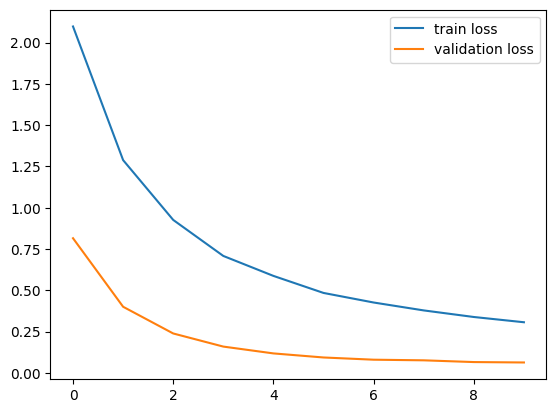

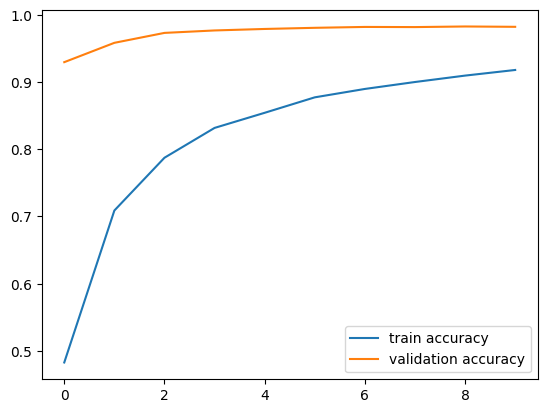

In [10]:
h = history

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], label='train accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()